<a href="https://colab.research.google.com/github/jadhav-rakesh/Cats_and_Dogs_Classifier/blob/main/cats_vs_dogs_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.python.keras import layers

In [2]:
(train_examples, validation_examples), info = tfds.load(
    "cats_vs_dogs",
     split=["train[:70%]", "train[70%:]"],
     with_info=True,
    as_supervised=True
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
IMAGE_RES = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

num_examples = info.splits["train"].num_examples

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [4]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [5]:
feature_extractor.trainable = False

In [6]:
import tf_keras

model = tf_keras.Sequential()

model.add(feature_extractor)
model.add(layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 module_wrapper (ModuleWrap  (None, 2)                 2562      
 per)                                                            
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [7]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

EPOCHS = 1

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data = validation_batches)

509/509 [==============================] - 65s 98ms/step - loss: 0.0611 - accuracy: 0.9780 - val_loss: 0.0372 - val_accuracy: 0.9881


In [8]:
class_names = np.array(info.features["label"].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [9]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 742ms/step


array(['dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat',
       'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog',
       'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat',
       'cat', 'dog', 'dog', 'dog', 'cat'], dtype='<U3')

In [10]:
print("Labels:", label_batch)
print("Predicted labels:", predicted_ids)

Labels: [1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0]
Predicted labels: [1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0]


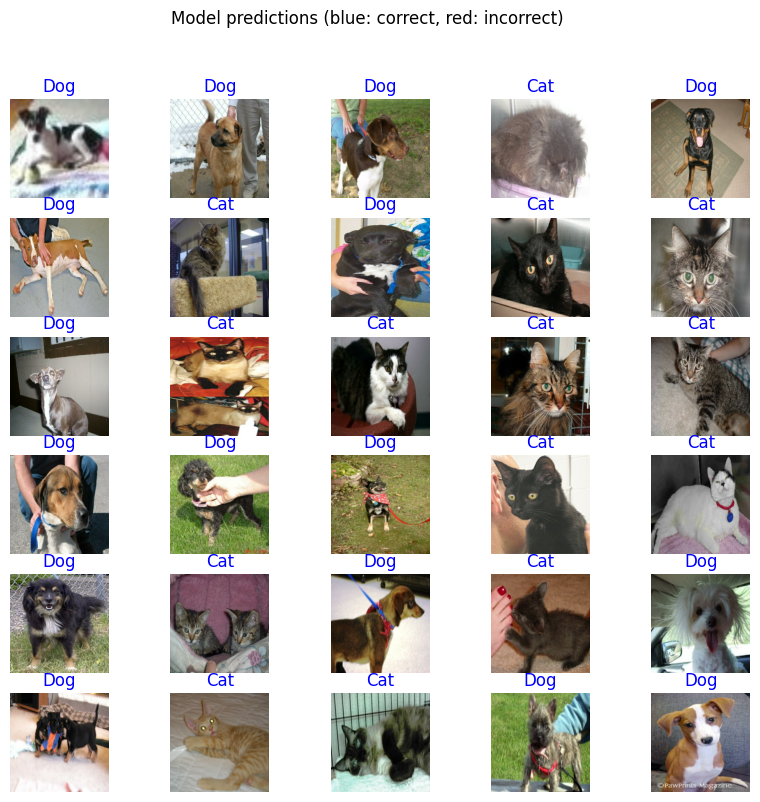

In [11]:
plt.figure(figsize=(10, 9))
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis("off")
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
t = time.time()

from tensorflow import keras

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

In [ ]:
!ls

In [ ]:
reloaded = tf.keras.model.load_model(
    export_path_keras,
    custom_objects={"KerasLayer":hub.KerasLayer}
)

reloaded.summary()

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
(abs(result_batch - reloaded_result_batch)).max()

In [ ]:
history = reloaded.fit(train_batches,
                       epochs=EPOCHS,
                       validation_data=validation_batches)

In [15]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1738656195


In [16]:
!ls (export_path_sm)

/bin/bash: -c: line 1: syntax error near unexpected token `export_path_sm'
/bin/bash: -c: line 1: `ls (export_path_sm)'


In [17]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [23]:
result_batch = model.predict(image_batch)
reloaded_sm_result_batch = reloaded_sm(image_batch, training=False)

1/1 [==============================] - 0s 72ms/step


In [24]:
(abs(result_batch - reloaded_sm_result_batch)).numpy()

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [39]:
t = time.time()

export_path_sm = "./{}.keras".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1738656699.keras


In [ ]:
reloaded_sm_keras = tf.keras.models.load_model(
    export_path_sm,
    custom_objects={"KerasLayer":hub.KerasLayer}
)

reloaded_sm_keras.summary()

In [ ]:
reloaded_sm_keras_result_batch = reloaded_sm_keras.predict(image_batch)

In [31]:
(abs(result_batch - reloaded_sm_keras_result_batch)).max()

NameError: name 'reloaded_sm_keras_result_batch' is not defined

In [44]:
!zip -r model.zip {export_path_sm}

  adding: 1738656699.keras/ (stored 0%)
  adding: 1738656699.keras/saved_model.pb (deflated 91%)
  adding: 1738656699.keras/assets/ (stored 0%)
  adding: 1738656699.keras/fingerprint.pb (stored 0%)
  adding: 1738656699.keras/variables/ (stored 0%)
  adding: 1738656699.keras/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1738656699.keras/variables/variables.index (deflated 78%)


In [ ]:
!ls

In [ ]:
try:
    from google.colab import files
    files.download("./model.zip")
except ImportError:
    pass